In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import PIL.ImageOps
import os
import pandas as pd    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
Helper functions
"""

# Display Image
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

**The dataset is of the following format:**

Image Directory

- Filepath to images

Data CSV

- CSV that contains the columns `Image 1 | Image 2 | Label`

In [ ]:
class cnnDataset():
    def __init__(self,input_df=None,input_dir=None,transform=None):
        # used to prepare the labels and images path
        self.input_df=input_df
        #self.input_df.columns =["image1","image2","label"]
        self.input_dir = input_dir    
        self.transform = transform

    def __getitem__(self,index):
        # getting the image path
        image1_path=os.path.join(self.input_dir,self.input_df.iat[index,0])
        image2_path=os.path.join(self.input_dir,self.input_df.iat[index,1])
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1 , torch.from_numpy(np.array([int(self.input_df.iat[index,2])],dtype=np.float32))
        
    def __len__(self):
        return len(self.input_df)

In [ ]:
# Network using ViT for feature extraction
class VGGNetwork(nn.Module):
    """
    VGG16 model using pretrained weights

    Parameters:
    -----------

    Attributes:
    -----------
    model_ver : 
      VGG16 pretrained model
    layers : list
      Selection of layers to use from VGG16 (feature extraction)
    feat_extractor : nn.Sequential
      Feature extraction layers to use
    head : nn.Sequential
      Pyramidal classification head
    flatten : nn.Flatten
      Flatten layer
    """

    def __init__(self):
        super(VGGNetwork, self).__init__()

        self.model_ver = models.vgg16(pretrained=True)
        self.layers = list(self.model_ver.children())[:-1]
        self.feat_extractor = nn.Sequential(*self.layers)
        
        self.head = nn.Sequential(
            nn.Linear(50176, 8192),
            nn.BatchNorm1d(8192),
            nn.ReLU(inplace=True),
            
            nn.Linear(8192, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        self.flatten = nn.Flatten()

    def forward(self, input1, input2):
        """
        Runs Forward Pass

        Parameters:
        -----------
        input1 : torch.Tensor
          (batch_size, in_chans, img_size, img_size)
        input2 : torch.Tensor
          (batch_size, in_chans, img_size, img_size)
        
        Returns:
        --------
        output : torch.Tensor
          (batch_size, prediction)
        """
        output1 = self.feat_extractor(input1)
        output2 = self.feat_extractor(input2)
        
        """Concatenate the image pair"""
        output = torch.cat((output1, output2), 1)
        
        """Flatten to send to FC layer"""
        output = self.flatten(output)
        
        output = self.head(output)

        return output

In [ ]:
# Unpacking uploaded data

!rm -rf data
!rm -rf model
!unzip "/content/drive/My Drive/Research/Spatial Reasoning/CNN Resources/data.zip" -d .
#!unzip "/content/drive/My Drive/Research/Spatial Reasoning/CNN Resources/model.zip" -d .

Archive:  /content/drive/My Drive/Research/Spatial Reasoning/CNN Resources/data.zip
   creating: ./data/
  inflating: ./data/check.csv        
   creating: ./data/testing/
 extracting: ./data/testing/1.jpg    
 extracting: ./data/testing/10.jpg   
 extracting: ./data/testing/11.jpg   
 extracting: ./data/testing/2.jpg    
  inflating: ./data/testing/3.jpg    
  inflating: ./data/testing/4.jpg    
 extracting: ./data/testing/5.jpg    
  inflating: ./data/testing/6.jpg    
  inflating: ./data/testing/7.jpg    
 extracting: ./data/testing/8.jpg    
 extracting: ./data/testing/9.jpg    
  inflating: ./data/testing_csv.csv  
   creating: ./data/training/
 extracting: ./data/training/1.jpg   
  inflating: ./data/training/10.jpg  
  inflating: ./data/training/11.jpg  
 extracting: ./data/training/12.jpg  
  inflating: ./data/training/13.jpg  
 extracting: ./data/training/14.jpg  
 extracting: ./data/training/15.jpg  
  inflating: ./data/training/16.jpg  
  inflating: ./data/training/17.jpg  


In [ ]:
model_file = "/content/drive/My Drive/Research/Spatial Reasoning/CNN Resources/model/vit_model.pth"

full_train_df = pd.read_csv('/content/data/training_csv.csv')
full_train_df.columns = ["image1","image2","label"]

testing_df = pd.read_csv('/content/data/testing_csv.csv')
testing_df.columns = ["image1","image2","label"]

training_dir = '/content/data/training'
testing_dir = '/content/data/testing'

check_df = pd.read_csv('/content/data/check.csv')
check_df.columns = ["image1","image2","label"]


"""Determining Train/Val split"""

validation_df = full_train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.2))
training_df = pd.concat([full_train_df, validation_df]).drop_duplicates(keep=False)

class_groups = training_df.groupby('label')
neg, pos = [class_groups.get_group(x) for x in class_groups.groups]

validation_df.reset_index(drop=True, inplace=True)
pos.reset_index(drop=True, inplace=True)
neg.reset_index(drop=True, inplace=True)

"""Sanity Check"""
print(f'Num rows in Training set: {len(training_df)}\nNum rows in Validation set: {len(validation_df)}')
print(full_train_df.groupby(['label']).count())
print(training_df.groupby(['label']).count())
print(validation_df.groupby(['label']).count())

print(f'\nPositive class (1); Size of class: {len(pos)}')
print(pos.head())
print(f'\nNegative class (0); Size of class: {len(neg)}')
print(neg.head())


"""

Create datasets

"""

validation_dataset = cnnDataset(validation_df,
                            training_dir,
                            transform=transforms.Compose([transforms.Resize((224,224)),
                                                          transforms.ToTensor()]))

testing_dataset = cnnDataset(testing_df,
                             testing_dir,
                             transform=transforms.Compose([transforms.Resize((224,224)),
                                                           transforms.ToTensor()]))

check_dataset = cnnDataset(check_df,
                           training_dir,
                           transform=transforms.Compose([transforms.Resize((224,224)),
                                                         transforms.ToTensor()]))

Num rows in Training set: 1411
Num rows in Validation set: 352
       image1  image2
label                
0        1252    1252
1         511     511
       image1  image2
label                
0        1002    1002
1         409     409
       image1  image2
label                
0         250     250
1         102     102

Positive class (1); Size of class: 409
  image1  image2  label
0  1.jpg  10.jpg      1
1  1.jpg   3.jpg      1
2  1.jpg  16.jpg      1
3  1.jpg  17.jpg      1
4  1.jpg  23.jpg      1

Negative class (0); Size of class: 1002
  image1  image2  label
0  1.jpg   5.jpg      0
1  1.jpg   6.jpg      0
2  1.jpg   7.jpg      0
3  1.jpg   8.jpg      0
4  1.jpg  11.jpg      0


In [ ]:
"""

Load Data

"""

val_dataloader = DataLoader(validation_dataset,
                            shuffle=True,
                            num_workers=2,
                            batch_size=16)

test_dataloader = DataLoader(testing_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=16)

check_dataloader = DataLoader(check_dataset,
                              shuffle=True,
                              num_workers=2,
                              batch_size=1)

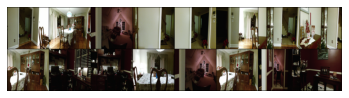

[0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Create a dataloader just for simple visualization
vis_dataloader = DataLoader(validation_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that the pair is of the positive class (spatially adjacent). 0 means negative.
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [ ]:
"""
Using BCE Loss for binary classification.
Using Adam optimizer with learning rate  = 5e-4
                          regularization = 1e-5
"""

model = VGGNetwork().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay = 1e-5)

In [ ]:
"""

Main Training Body

"""

train_loss = []
train_acc = []
val_acc = [] 
val_loss = []
num_epochs = 30

"""Determining the best model"""
last_best = np.inf
best_so_far = None

"""Indices used for balanced training set"""
start_ind = 0
end_ind = len(pos)

for epoch in range(num_epochs):
  print(f'Epoch: {epoch}')

  running_val_loss, running_train_loss  = 0, 0
  running_train_acc, running_val_acc    = 0, 0

  """Creating balanced training set""" 
  idx = np.arange(start_ind, end_ind, 1) % len(neg)

  curr_train_set = pd.concat([pos, neg.iloc[idx]])

  training_dataset = cnnDataset(curr_train_set, 
                                training_dir,
                                transform=transforms.Compose([transforms.Resize((224,224)),
                                                              transforms.ToTensor()]))
  train_dataloader = DataLoader(training_dataset,
                                shuffle=True,
                                num_workers=2,
                                batch_size=16)

  """Training Loop"""
  for img0, img1, label in tqdm(train_dataloader, total=len(train_dataloader)):
    model.train()

    img0, img1, label = img0.to(device), img1.to(device), label.to(device)

    optimizer.zero_grad()

    output = model(img0, img1)

    loss_bce = criterion(output, label)
    loss_bce.backward()

    optimizer.step()

    """Collect training accuracy"""
    cut = np.array([int(x >= 0.5) for x in output.detach().cpu().numpy()]).reshape((len(label), 1))

    train_batch_acc = np.sum(np.equal(cut, label.detach().cpu().numpy())) / len(cut)

    running_train_acc += train_batch_acc

    """Collect training loss"""
    running_train_loss += loss_bce.item()

  """Validation Loop"""
  with torch.no_grad():
    model.eval()

    for i, (v_img0, v_img1, v_label) in enumerate(val_dataloader, 0):

      v_img0, v_img1, v_label = v_img0.to(device), v_img1.to(device), v_label.to(device)

      v_output = model(v_img0, v_img1)

      v_loss = criterion(v_output, v_label)

      running_val_loss += v_loss.item()
      
      cut = np.array([int(x >= 0.5) for x in v_output.detach().cpu().numpy()]).reshape((len(v_label), 1))

      val_batch_acc = np.sum(np.equal(cut, v_label.detach().cpu().numpy())) / len(cut)

      running_val_acc += val_batch_acc

  """Determine average loss"""
  train_loss_avg  = running_train_loss / len(train_dataloader)
  val_loss_avg    = running_val_loss / len(val_dataloader)

  """Determine average acc"""
  train_acc_avg = running_train_acc / len(train_dataloader)
  val_acc_avg = running_val_acc / len(val_dataloader)

  print(f" Training loss {train_loss_avg} Validation loss {val_loss_avg}\n Training Acc {train_acc_avg} Validation Acc {val_acc_avg}\n")

  """Save best model so far"""
  if val_loss_avg < last_best:
    print("Saving new best model...\n")
    best_so_far = model.state_dict()
    
    last_best = val_loss_avg

  train_loss.append(train_loss_avg)
  val_loss.append(val_loss_avg)

  train_acc.append(train_acc_avg)
  val_acc.append(val_acc_avg)

  start_ind += len(pos)
  end_ind += len(pos)

Epoch: 0


100%|██████████| 52/52 [01:16<00:00,  1.48s/it]


 Training loss 0.39367573966200536 Validation loss 0.6096436354247007
 Training Acc 0.8173076923076923 Validation Acc 0.59375

Saving new best model...

Epoch: 1


100%|██████████| 52/52 [01:22<00:00,  1.60s/it]


 Training loss 0.5114125408805333 Validation loss 0.6275535930286754
 Training Acc 0.7572115384615384 Validation Acc 0.6448863636363636

Epoch: 2


100%|██████████| 52/52 [01:22<00:00,  1.58s/it]


 Training loss 0.5081752544412246 Validation loss 0.8630653782324358
 Training Acc 0.7584134615384616 Validation Acc 0.5085227272727273

Epoch: 3


100%|██████████| 52/52 [01:18<00:00,  1.51s/it]


 Training loss 0.5327814295887947 Validation loss 0.507751235907728
 Training Acc 0.7259615384615384 Validation Acc 0.71875

Saving new best model...

Epoch: 4


100%|██████████| 52/52 [01:20<00:00,  1.54s/it]


 Training loss 0.45168797786419207 Validation loss 0.6790030354803259
 Training Acc 0.8112980769230769 Validation Acc 0.6079545454545454

Epoch: 5


100%|██████████| 52/52 [01:20<00:00,  1.54s/it]


 Training loss 0.4909659641293379 Validation loss 0.6346924636851657
 Training Acc 0.7548076923076923 Validation Acc 0.7102272727272727

Epoch: 6


100%|██████████| 52/52 [01:15<00:00,  1.45s/it]


 Training loss 0.5405123182214223 Validation loss 1.0999166396531193
 Training Acc 0.7403846153846154 Validation Acc 0.3125

Epoch: 7


100%|██████████| 52/52 [01:11<00:00,  1.37s/it]


 Training loss 0.568764617236761 Validation loss 0.6600649113004858
 Training Acc 0.7103365384615384 Validation Acc 0.5454545454545454

Epoch: 8


100%|██████████| 52/52 [01:11<00:00,  1.37s/it]


 Training loss 0.5691705065277907 Validation loss 0.6886565360155973
 Training Acc 0.6862980769230769 Validation Acc 0.6363636363636364

Epoch: 9


100%|██████████| 52/52 [01:10<00:00,  1.36s/it]


 Training loss 0.5025809561977019 Validation loss 0.5329073450782082
 Training Acc 0.7451923076923077 Validation Acc 0.7215909090909091

Epoch: 10


100%|██████████| 52/52 [01:10<00:00,  1.36s/it]


 Training loss 0.5132025795487257 Validation loss 1.6311959082430059
 Training Acc 0.7127403846153846 Validation Acc 0.29829545454545453

Epoch: 11


100%|██████████| 52/52 [01:09<00:00,  1.34s/it]


 Training loss 0.5416617860587744 Validation loss 0.5758688720789823
 Training Acc 0.7271634615384616 Validation Acc 0.6960227272727273

Epoch: 12


100%|██████████| 52/52 [01:10<00:00,  1.35s/it]


 Training loss 0.5347582755180506 Validation loss 0.6609536057168787
 Training Acc 0.7355769230769231 Validation Acc 0.7528409090909091

Epoch: 13


100%|██████████| 52/52 [01:11<00:00,  1.38s/it]


 Training loss 0.480667498249274 Validation loss 0.5926187620921568
 Training Acc 0.7680288461538461 Validation Acc 0.6846590909090909

Epoch: 14


100%|██████████| 52/52 [01:11<00:00,  1.37s/it]


 Training loss 0.45587916328356815 Validation loss 1.1048799644817004
 Training Acc 0.8028846153846154 Validation Acc 0.53125

Epoch: 15


100%|██████████| 52/52 [01:12<00:00,  1.39s/it]


 Training loss 0.474742920925984 Validation loss 0.6109084243124182
 Training Acc 0.7860576923076923 Validation Acc 0.7102272727272727

Epoch: 16


  0%|          | 0/52 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

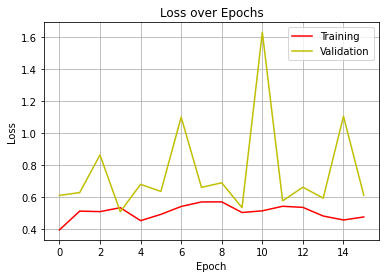

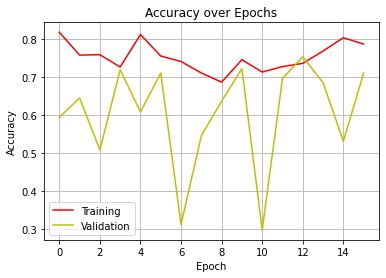

Average Training Accuracy   : 0.7524789663461539

Average Validation Accuracy : 0.6045809659090909



In [ ]:
"""
Visualization of loss over epochs
"""

plt.plot(np.arange(len(train_loss)), train_loss, c='r')
plt.plot(np.arange(len(val_loss)), val_loss, c='y')
plt.legend(['Training','Validation'])
plt.grid(True)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

"""
Visualization of accuracy over epochs
"""

plt.plot(np.arange(len(train_acc)), train_acc, c='r')
plt.plot(np.arange(len(val_acc)), val_acc, c='y')
plt.legend(['Training','Validation'])
plt.grid(True)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

print(f"Average Training Accuracy   : {np.mean(train_acc)}\n")
print(f"Average Validation Accuracy : {np.mean(val_acc)}\n")

In [ ]:
print(model)

In [ ]:
"""Save model"""
torch.save(best_so_far, model_file)

In [ ]:
"""Test model"""
#model.load_state_dict(torch.load(model_file))
acc = []
test_loss = []

with torch.no_grad():
  model.eval()
  for img0, img1, label in tqdm(test_dataloader, total=len(test_dataloader)):
    img0, img1, label = img0.to(device), img1.to(device), label.to(device)

    output = model(img0, img1)

    loss = criterion(output, label)
    test_loss.append(loss.item())

    cut = np.array([int(x >= 0.5) for x in output.detach().cpu().numpy()]).reshape((len(label), 1))

    batch_acc = np.sum(np.equal(cut, label.detach().cpu().numpy())) / len(cut)

    acc.append(batch_acc)

acc = np.array(acc)
test_loss = np.array(test_loss)
print(f"\nAverage Test Accuracy across batches: {np.mean(acc)}\nAverage Test Loss across batches: {np.mean(test_loss)}")

100%|██████████| 8/8 [00:10<00:00,  1.35s/it]

Average Test Accuracy across batches: 0.4296875
Average Test Loss across batches: 1.3457073867321014


## Test Result Visualization and Check Results

In [ ]:
#model.load_state_dict(torch.load(model_file))

test_vis_loader = DataLoader(testing_dataset,
                             shuffle=True,
                             num_workers=2,
                             batch_size=1)

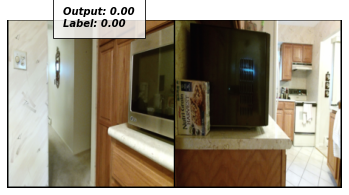

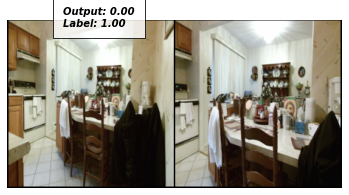

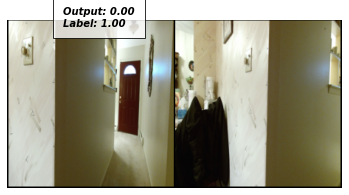

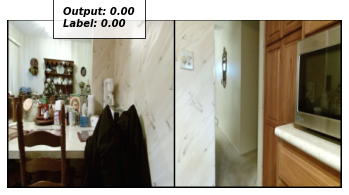

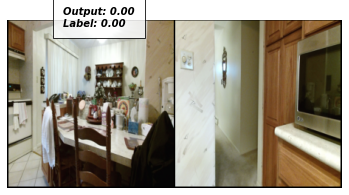

In [ ]:
test_data_iter = iter(test_vis_loader)

with torch.no_grad():
  model.eval()
  for i in range(5):
    img1, img2, label = next(test_data_iter)
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)

    img_pair = torch.cat((img1, img2), 0)

    output = model(img1, img2)

    cut = [int(x >= 0.5) for x in output.detach().cpu().numpy()]

    imshow(torchvision.utils.make_grid(img_pair.detach().cpu()), f'Output: {cut[0]:.2f}\nLabel: {label.item():.2f}')

tensor([[0.1281]], device='cuda:0')


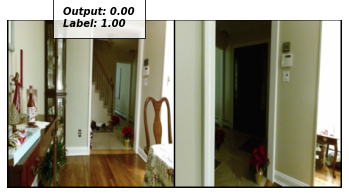

tensor([[0.0452]], device='cuda:0')


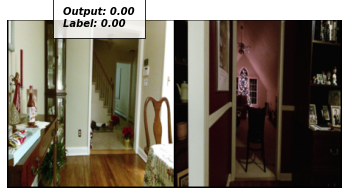

tensor([[0.0298]], device='cuda:0')


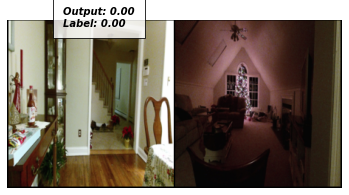

tensor([[0.0457]], device='cuda:0')


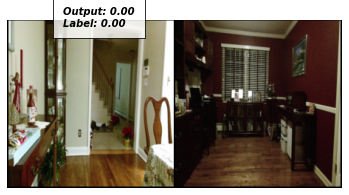

tensor([[0.0387]], device='cuda:0')


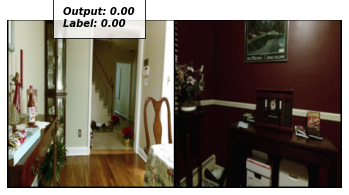

In [ ]:
check_data_iter = iter(check_dataloader)

with torch.no_grad():
  model.eval()
  for i in range(5):
    img1, img2, label = next(check_data_iter)
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)


    img_pair = torch.cat((img1, img2), 0)

    output = model(img1, img2)

    cut = [int(x >= 0.5) for x in output.detach().cpu().numpy()]

    imshow(torchvision.utils.make_grid(img_pair.detach().cpu()), f'Output: {cut[0]:.2f}\nLabel: {label.item():.2f}')